<a href="https://colab.research.google.com/github/jvallikivi/mlmi4-vcl/blob/main/Generative_NOT_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.distributions import kl_divergence, Normal
from collections import OrderedDict
from torchvision import datasets
from torchvision import transforms
from torchvision.datasets import ImageFolder
import os, tarfile

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 0.001
batch_size = 50
n_epochs = 400

In [3]:
class BayesLinear(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight_loc = nn.Parameter(torch.zeros(in_features, out_features))
        self.log_weight_scale = nn.Parameter(torch.zeros(in_features, out_features))

        self.bias_loc = nn.Parameter(torch.zeros(out_features))
        self.log_bias_scale = nn.Parameter(torch.zeros(out_features))
        
        self.weight = self.weight_loc.data.clone().to(device)
        self.bias = self.bias_loc.data.clone().to(device)



    def get_params(self):
        """
        return two tensors, obtaining by concatenating locs and scales together
        these parameters can be further used to calculate e.g, KL divergence (vectorizedly)
        """
        return (
                torch.cat([self.weight_loc.flatten(), self.bias_loc.flatten()]), 
                torch.cat([self.log_weight_scale.flatten(), self.log_bias_scale.flatten()])
               )

    
    def forward(self, x,  activition_fn=None):

        y = x @ self.weight + self.bias
        if activition_fn:
            return activition_fn(y)
        return y


In [4]:
class Encoder(nn.Module):

    def __init__(self, 
                 input_size, 
                 in_features, 
                 out_features, 
                 n_layers,                 ):
        """
        """
        super(Encoder, self).__init__()
        self.x_to_h = nn.ModuleList( [self.get_layer(input_size, in_features, True)] + 
                                    [self.get_layer(in_features, in_features, True) for _ in range(n_layers - 1)]).to(device)
        self.head = nn.ModuleList([self.get_layer(in_features, out_features, True) for _ in range(2)]).to(device)
                                    # + [self.get_layer(in_features, out_features)]).to(device)


    def get_layer(self, in_feature, out_features, activation=False):
        layer = nn.Linear(in_feature, out_features)
        return layer

In [28]:
# I used their evaluation function and adjusted for torch for consistency
def gaussian_prob(x, loc=0., log_scale=torch.Tensor([0.]).to(device)):
    p1 = -torch.log(torch.Tensor([2 * torch.pi]).to(device))/2 + log_scale
    p2 = -.5*((x - loc)/torch.exp(log_scale))**2
    prob = (p1 + p2).sum(1) 
    return prob


def bernoulli_prob(x, p=torch.Tensor([0.5]).to(device)):
    p1 = x * torch.log(torch.clamp(p, 1e-9, 1.0))
    p2 = (1 - x) * torch.log(torch.clamp(1.0 - p, 1e-9, 1.0))
    prob = (p1 + p2).sum(1)

    return prob

def evaluate(model, test_batch):
    test_batch = test_batch.repeat(100, 1)
    loc, log_scale = model.encoder_forward(test_batch) 
    z = torch.randn_like(loc) * torch.exp(log_scale) + loc
    gen = model.decoder_forward(z, sampling=True)
    kl =  gaussian_prob(z, loc, log_scale) - gaussian_prob(z)
    bce = bernoulli_prob(test_batch, gen)
    test_ll = (bce - kl).reshape((100, batch_size))
    max = test_ll.max(0)[0]
    test_ll = torch.log(torch.clamp_min(torch.exp(test_ll - max).mean(0), 1e-9)) + max
    mean = test_ll.mean()
    var = ((test_ll - mean) ** 2).mean()
    return mean, var

In [13]:
class VCL_Generator(nn.Module):
    def __init__(self, previous_model, 
                 nencoder_layers=3, ndecoder_layers=1, 
                 z_dim=50, h_dim=500, x_dim=784, random_initialize=False):
        super().__init__()
        
        self.ndecoder_layers = ndecoder_layers
        self.z_dim = z_dim

        #######ENCODER PART

        self.encoder = Encoder(input_size=x_dim,
                                in_features=h_dim,
                                out_features=z_dim,
                                n_layers=nencoder_layers).to(device)
        self.x_to_h = self.encoder.x_to_h#.to(device)
        self.encoder_head = self.encoder.head#.to(device)

        ######GENERATOR PART


        self.decoder_head = nn.ModuleList([BayesLinear(z_dim, h_dim)] +
                                          [BayesLinear(h_dim, h_dim) for _ in range(self.ndecoder_layers)]).to(device) 
        self.h_to_x = nn.ModuleList( [BayesLinear(h_dim, x_dim)]).to(device)
        
        
        # define a layer dict
        self.layer_dict = OrderedDict()
        for ix, layer in enumerate(self.x_to_h):
            self.layer_dict[f'x_to_h_{ix}'] = layer

        for ix, layer in enumerate(self.h_to_x):
            self.layer_dict[f'h_to_x_{ix}'] = layer
        
        for ix, layer in enumerate(self.decoder_head):
            self.layer_dict[f'decoder_head_{ix}'] = layer

        self.layer_dict["encoder_head"] = self.encoder_head

        # just a sanity check 
        assert id(self.layer_dict[f"x_to_h_{0}"]) == id(self.x_to_h[0])
        
        
        with torch.no_grad():
            if previous_model != None:
                for key in self.layer_dict:
                    if "decoder_head" in key or "h_to_x" in key:
                        self.layer_dict[key].weight_loc.data = previous_model.layer_dict[key].weight_loc.data.clone()
                        self.layer_dict[key].bias_loc.data = previous_model.layer_dict[key].bias_loc.data.clone()
                        self.layer_dict[key].log_weight_scale.data  = previous_model.layer_dict[key].log_weight_scale.data.clone()
                        self.layer_dict[key].log_bias_scale.data  = previous_model.layer_dict[key].log_bias_scale.data.clone()
                    else:
                        self.layer_dict[key] = previous_model.layer_dict[key]
            if random_initialize:
                for layer in self.h_to_x + self.decoder_head:
                    layer.log_weight_scale = nn.Parameter(torch.ones(layer.log_weight_scale.shape, device=device) * -6)
                    layer.log_bias_scale = nn.Parameter(torch.ones(layer.log_bias_scale.shape, device=device) * -6)
                    torch.nn.init.xavier_uniform_(layer.weight_loc)
        
        if  previous_model != None:
            previous_locs, previous_logscales = previous_model.get_params()
            self.previous_model_locs = previous_locs
            self.previous_model_log_scales = previous_logscales
        else:
            self.previous_model_locs = None
            self.previous_model_log_scales = None


    def encoder_forward(self, x):
        for layer in self.x_to_h:
            x = layer(x)
            x = nn.ReLU()(x)
        loc = self.encoder_head[0](x)
        log_scale = self.encoder_head[1](x)
        return loc, log_scale

    
    def decoder_forward(self, z, sampling=False):
        size = len(self.decoder_head + self.h_to_x)
        
        for ix, layer in enumerate(self.decoder_head + self.h_to_x):
            if sampling:
                layer.weight = torch.randn_like(layer.weight_loc) * torch.exp(layer.log_weight_scale) + layer.weight_loc
                layer.bias = torch.randn_like(layer.bias_loc) * torch.exp(layer.log_bias_scale) + layer.bias_loc
            z = layer(z, nn.Sigmoid())
        return z


    def get_params(self):  
        locs = []
        logscales = []
        for layer in self.h_to_x:
            loc, scale = layer.get_params()
            locs.append(loc)
            logscales.append(scale)
        return locs, logscales

    def calculate_loss(self, x, 
                    #    y, 
                       n_particles=10, dataset_size=6000):
        
        locs, logscales = self.get_params()
        # calculate KL between "prior" and posterior
        size = len(locs)
        kl = 0
        for ix in range(size):
            KL = kl_divergence(Normal(loc=locs[ix], scale=torch.exp(logscales[ix])),
                                Normal(loc=self.previous_model_locs[ix], scale=torch.exp(self.previous_model_log_scales[ix]))
                            )
            kl += KL.sum()/dataset_size 

        loc, log_scale = self.encoder_forward(x) 
        kl_z = kl_divergence(Normal(loc, torch.exp(log_scale)), 
                             Normal(0., torch.exp(torch.Tensor([0.]).to(device))))
        bce = 0.
        for _ in range(n_particles):
            z = torch.randn_like(loc) * torch.exp(log_scale) + loc
            gen = self.decoder_forward(z, sampling=True)
            bce = bce + torch.nn.functional.binary_cross_entropy(input=gen, target=x, reduction="sum")
            

        loss = (kl_z.sum() + bce / n_particles) / x.shape[0] + kl
        return loss  

In [7]:

## dataset
tar_file = 'notMNIST_small.tar.gz'
folder = './data/notMNIST_small/'
if not os.path.exists(folder):
    if not os.path.exists(tar_file):
        raise Exception("notMNIST dataset is missing, download at: https://www.kaggle.com/datasets/lubaroli/notmnist")
    with tarfile.open(tar_file) as f:
        f.extractall('./data/')
    assert os.path.exists(folder), "Something went wrong with extraction."

# these are some empty images
empty_files = ['A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png', 'F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png']
for file_name in empty_files:
    file_name = f"{folder}/{file_name}"
    if os.path.exists(file_name):
        os.remove(file_name)


transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor()
])

image_folder = ImageFolder(folder, transform=transform)

def get_alpha(task_idx):
    class_data = torch.concatenate([item for item, label in image_folder if label==task_idx])
    class_data = nn.Flatten()(class_data)
    data_size = class_data.shape[0]
    test_size = data_size *1//10
    perm = torch.randperm(data_size)
    train_idx = perm[:-test_size]
    test_idx = perm[-test_size:]
    train = class_data[train_idx]
    test = class_data[test_idx]
    return train.to(device), test.to(device)

In [8]:
image_folder.classes

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']

In [11]:
%mkdir models

100%|██████████| 400/400 [04:45<00:00,  1.40it/s]


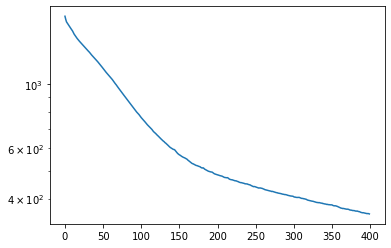

100%|██████████| 400/400 [04:41<00:00,  1.42it/s]


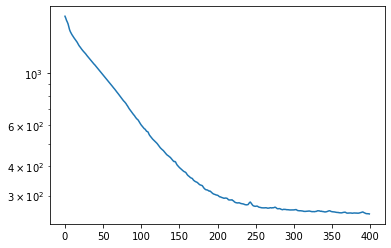

100%|██████████| 400/400 [04:41<00:00,  1.42it/s]


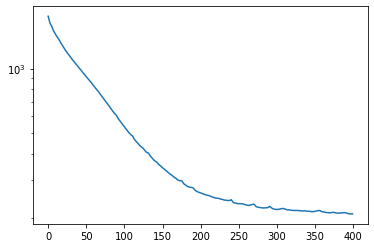

100%|██████████| 400/400 [04:40<00:00,  1.43it/s]


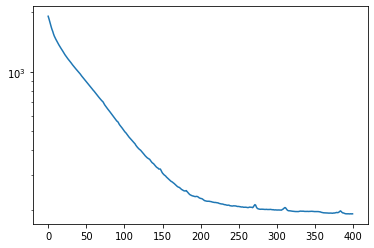

100%|██████████| 400/400 [04:40<00:00,  1.43it/s]


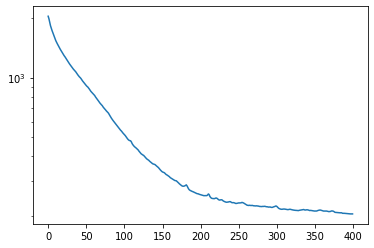

100%|██████████| 400/400 [04:38<00:00,  1.44it/s]


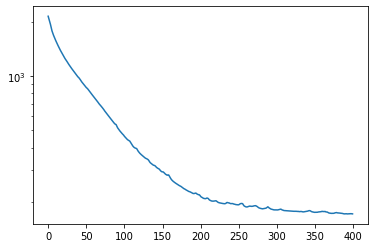

100%|██████████| 400/400 [04:37<00:00,  1.44it/s]


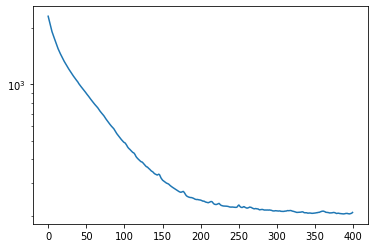

100%|██████████| 400/400 [04:35<00:00,  1.45it/s]


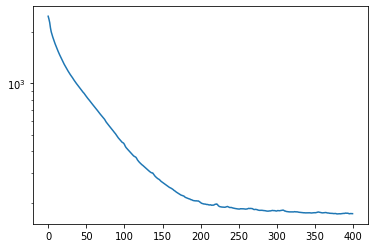

100%|██████████| 400/400 [04:36<00:00,  1.45it/s]


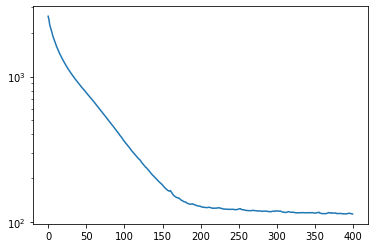

100%|██████████| 400/400 [04:39<00:00,  1.43it/s]


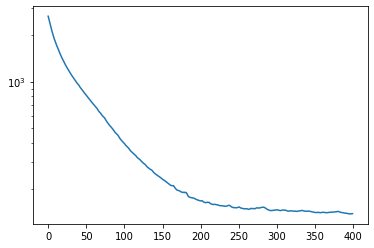

In [14]:
import copy
previous_model = VCL_Generator(previous_model=None).to(device) # initialize a prior model
lr = 0.001
models = []
test_data = []
for alpha_id in range(10): #
    train_x, test_x = get_alpha(alpha_id)
    current_model = VCL_Generator(previous_model=previous_model, random_initialize=True).to(device)
    current_opt = torch.optim.Adam(current_model.parameters(), lr=lr)
    train_losses = []
    dataset_size = train_x.shape[0]
    # if alpha_id == 0:
    #     n_epochs = 600
    # else:
    n_epochs = 400
    for epoch in tqdm(range(n_epochs)):
        loss_batch = []
        for batch in range(int(np.ceil(train_x.shape[0] / batch_size))):
            batch_idx0 = batch * batch_size
            batch_idx1 = batch * batch_size + batch_size
            
            current_opt.zero_grad()
            loss = current_model.calculate_loss(x=train_x[batch_idx0: batch_idx1].to(device), 
                                                # y=train_y[batch_idx0: batch_idx1].to(device), 
                                                n_particles=10,
                                                dataset_size=dataset_size
                                                )
            loss.backward()
            nn.utils.clip_grad_value_(current_model.parameters(), 1)
            current_opt.step()
            loss_batch.append(loss.item())
        train_losses.append(np.mean(loss_batch))
    test_data.append(test_x)
    plt.plot(train_losses)
    plt.yscale("log")
    plt.show()
    models.append(copy.copy(current_model))
    torch.save(current_model.state_dict(), f"models/model_task{alpha_id}")
    previous_model = current_model

In [37]:
train_losses

[2664.873930089614,
 2552.1143224379593,
 2431.251752068015,
 2331.570951573989,
 2220.9704877068016,
 2125.261266371783,
 2044.0036908318016,
 1964.1898301068475,
 1897.397320915671,
 1836.812349207261,
 1780.7791999368108,
 1728.4626141716453,
 1679.6082691865809,
 1632.0742833754596,
 1586.6243537454045,
 1542.293119542739,
 1502.0066348805146,
 1463.7100112017463,
 1428.5590281767004,
 1396.0061573701746,
 1363.6756519990809,
 1332.0844762465533,
 1303.0670596852021,
 1275.6342809340533,
 1249.4232105928309,
 1225.06103515625,
 1201.9156494140625,
 1178.4882848403033,
 1157.6445635627297,
 1136.6014871036305,
 1114.273017434513,
 1094.4908124138328,
 1076.9421458524816,
 1059.9249734317555,
 1041.5598180434283,
 1023.7552615894991,
 1007.0087244370404,
 990.0154454848346,
 974.8202676212086,
 962.2926474178539,
 949.81615672392,
 932.2110847024356,
 915.9582304113052,
 901.9067957261029,
 888.4265316233915,
 874.9282244514017,
 862.6686329561121,
 850.070504581227,
 837.97295065487

In [15]:
def generate_image(head, generator, z):
    with torch.no_grad():
        for layer in head:
            z = layer.forward(z, nn.Sigmoid())
        for layer in generator:
            z = layer.forward(z, nn.Sigmoid())
    z = z.detach().cpu()
    n_digits = int(z.shape[0] ** .5)
    if n_digits > 1:
        z =  z.reshape((n_digits, n_digits, 28, 28))
        image = np.concatenate([el for el in z], axis=-1)
        image = np.concatenate([el for el in image], axis=0)    
    else:
        image = z.reshape((28, 28))
    return image

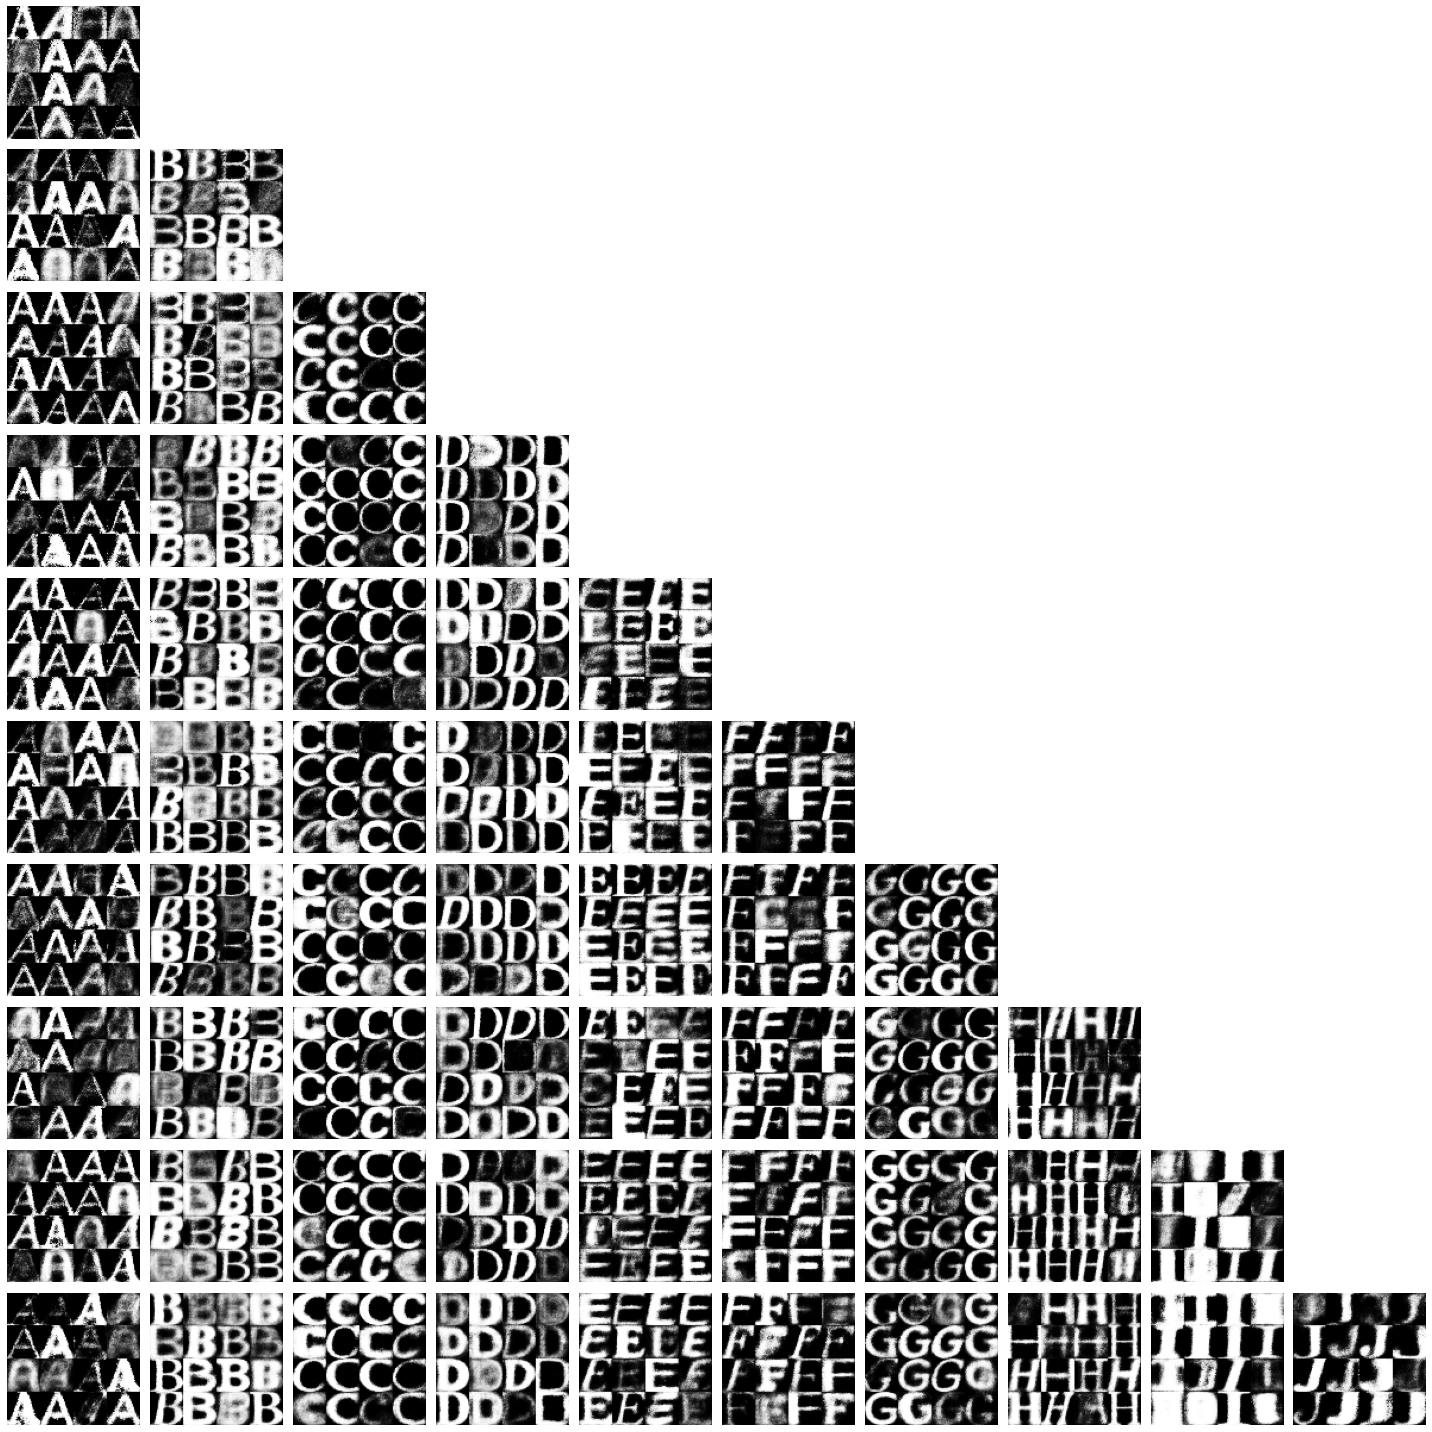

In [16]:
nrows, ncols = 10, 10
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20))
for i in range(nrows):
    for j in range(ncols):
        axes[i, j].axis('off')
fig.tight_layout()
for ix1, model1 in enumerate(models):
    cnt = 0
    z = torch.randn(16, 50).to(device)
    image = generate_image(model1.decoder_head, model1.h_to_x, z)
    axes[cnt+ix1, ix1].imshow(image, cmap="gray")
    axes[cnt+ix1, ix1].axis('off')

    for ix2, model2 in enumerate(models[ix1+1:]):
        cnt += 1
        z = torch.randn(16, 50).to(device)
        image = generate_image(model1.decoder_head, model2.h_to_x, z)
        axes[cnt+ix1, ix1].imshow(image, cmap="gray")
        axes[cnt+ix1, ix1].axis('off')

In [42]:
def get_test_sample(data, task_id=0):
    task_images = data[task_id]
    size = len(task_images)
    ix = np.random.randint(size)
    image = task_images[ix].detach().cpu().reshape(28, 28)
    return image

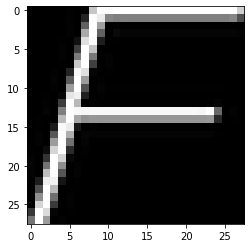

In [69]:
plt.imshow(get_test_sample(test_data, task_id=2000), cmap="gray")

In [62]:
len(test_data)

4000

In [70]:
def calculate_alpha_ll(digit_num):
    # _, test_x = get_alpha(digit_num)
    test_x = test_data[digit_num*400]
    model = VCL_Generator(previous_model=None)
    model.load_state_dict(torch.load(f"models/model_task{digit_num}"))
    nbatches = test_x.shape[0] // batch_size
    lls = []
    ll_total = 0.
    for batch in range(nbatches):
        batch_idx0 = batch * batch_size
        batch_idx1 = batch * batch_size + batch_size
        ll, _ = evaluate(model, test_x[batch_idx0: batch_idx1])
        ll_total += ll/nbatches

    lls.append(ll_total.detach().item())
    try:
        for i in range(digit_num+1, 10, 1):
            model1 = VCL_Generator(previous_model=None)
            model1.load_state_dict(torch.load(f"models/model_task{i}"))
            model.h_to_x = copy.copy(model1.h_to_x)
            ll_total = 0.
            for batch in range(nbatches):
                batch_idx0 = batch * batch_size
                batch_idx1 = batch * batch_size + batch_size
                ll, _ = evaluate(model, test_x[batch_idx0: batch_idx1])
                ll_total += ll/nbatches
            lls.append(ll_total.detach().item())
    except:
        pass

    return lls

In [71]:
from collections import defaultdict
test_ll_dict = defaultdict(list)
for i in tqdm(range(10)):
    test_ll_dict[i] = calculate_alpha_ll(i)

100%|██████████| 10/10 [00:02<00:00,  4.35it/s]


In [72]:
test_ll_dict

defaultdict(list,
            {0: [-221.92251586914062,
              -223.20887756347656,
              -222.68975830078125,
              -225.39755249023438,
              -227.50733947753906,
              -227.08462524414062,
              -224.72930908203125,
              -226.42825317382812,
              -233.76588439941406,
              -238.00302124023438],
             1: [-219.99359130859375,
              -217.19696044921875,
              -218.2383575439453,
              -217.26437377929688,
              -216.95846557617188,
              -216.312255859375,
              -216.6030731201172,
              -216.19155883789062,
              -216.108642578125],
             2: [-177.70162963867188,
              -176.0793914794922,
              -174.3870849609375,
              -175.37887573242188,
              -173.771484375,
              -175.22930908203125,
              -174.89212036132812,
              -175.62234497070312],
             3: [-155.79022216796875,


In [73]:
avg_dict = defaultdict(list)
for ix, alpha in enumerate(image_folder.classes):
    avg_dict[ix].append(test_ll_dict[ix][0])
    for ix1 in range(1, ix + 1):
        avg_dict[ix].append(test_ll_dict[ix - ix1][ix1])

In [74]:
for ix, alpha in enumerate(image_folder.classes):
    print(alpha, f"avg: {np.mean(avg_dict[ix])}")

A avg: -221.92251586914062
B avg: -221.60123443603516
C avg: -205.86278279622397
D avg: -193.87638092041016
E avg: -191.88499450683594
F avg: -187.69964853922525
G avg: -188.3278067452567
H avg: -184.91356658935547
I avg: -178.00482686360678
J avg: -172.5167137145996
